# Evaluation of Analyzers using Input Perturbations

This notebook will guide you through an example of how to evaluate analyzers via perturbing the input according to the importance that the analysis method attribute to input regions.

The input images are divided into quadratic regions that are sorted according to their importance w.r.t. to the pixel-wise saliency scores assigned by those analyzers. Then, the information content of the image is gradually destroyed by perturbation of the most important regions. The effect of this perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed and remains largely unaffected when perturbing unimportant regions.

Thus, different analyzers can be compared by measuring how quickly their performance drops, i.e. the quicker the classifier performance drops after input perturbation w.r.t. to the prediction analysis, the better the analyzer is capable of identifying the input components responsible for the output of the model.

Similarly, several models can be compared, e.g. with random perturbations on the data, towards their resilience to noisy input data: The faster the model prediction declines with ongoing perturbations, the more susceptible the classifier is to noise.

Reference:

*[Samek et al.](http://dx.doi.org/10.1109/TNNLS.2016.2599820)*, "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

-----

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

import imp
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils
from innvestigate.tools.perturbate import Perturbation, PerturbationAnalysis

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.mnist as mnistutils

# Data
Then, the MNIST data is loaded in its entirety, formatted according to the specifications of the Keras backend.

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(
    x_train, input_range
)

# Preprocess data
data = (
    preprocess(x_train),
    y_train,
    preprocess(x_test),
    y_test,
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_test, y_test = data[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.sequence.BatchSequence([x_test, y_test], batch_size=256)

# Model

The next part trains and evaluates a CNN.

In [4]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

scores = mnistutils.train_model(model, data, batch_size=128, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 33s 556us/sample - loss: 0.1482 - accuracy: 0.9550
Epoch 2/10
60000/60000 [==============================] - 34s 573us/sample - loss: 0.0373 - accuracy: 0.9887
Epoch 3/10
60000/60000 [==============================] - 36s 597us/sample - loss: 0.0222 - accuracy: 0.9930
Epoch 4/10
60000/60000 [==============================] - 38s 639us/sample - loss: 0.0144 - accuracy: 0.9954
Epoch 5/10
60000/60000 [==============================] - 41s 681us/sample - loss: 0.0105 - accuracy: 0.9964
Epoch 6/10
60000/60000 [==============================] - 40s 662us/sample - loss: 0.0070 - accuracy: 0.9977
Epoch 7/10
60000/60000 [==============================] - 40s 659us/sample - loss: 0.0044 - accuracy: 0.9987
Epoch 8/10
60000/60000 [==============================] - 39s 646us/sample - loss: 0.0086 - accuracy: 0.9972
Epoch 9/10
60000/60000 [==============================] - 40s 659us/sample - loss: 0.0063 - accuracy: 0.9

# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `regions_per_step`: In each perturbation step, the `regions_per_step` regions are perturbed.

Feel free to play around with different analyzers, e.g. by selecting them from the `methods` list via `selected_methods_indices`.

In [5]:
perturbation_function = "gaussian"
region_shape = (7, 7)
steps = 15
regions_per_step = 1  # Perturbate 1 region per step


# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255


noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
# fmt: off
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN            TITLE
    # Show input
    ("input",               {},                         input_postprocessing,   "Input"),
    # Random
    ("random",              {},                         mnistutils.graymap,     "Random"),
    # Function
    ("gradient",            {"postprocess": "abs"},     mnistutils.graymap,     "Gradient"),
    ("smoothgrad",
                            {"noise_scale": noise_scale, 
                             "postprocess": "square"},  mnistutils.graymap,     "SmoothGrad"),
    # Signal
    ("deconvnet",           {},                         mnistutils.bk_proj,     "Deconvnet"),
    ("guided_backprop",     {},                         mnistutils.bk_proj,     "Guided Backprop"),
    # Interaction
    ("deep_taylor.bounded", {"low": input_range[0], 
                             "high": input_range[1]},   mnistutils.heatmap,     "DeepTaylor"),
    ("input_t_gradient",    {},                         mnistutils.heatmap,     "Input * Gradient"),
    ("integrated_gradients",{"reference_inputs": ri},   mnistutils.heatmap,     "Integrated Gradients"),
    ("lrp.z",               {},                         mnistutils.heatmap,     "LRP-Z"),
    ("lrp.epsilon",         {"epsilon": 1},             mnistutils.heatmap,     "LRP-Epsilon"),
]
# fmt: on

# Select methods of your choice
selected_methods_indices = [1, 2, 3, 7]
selected_methods = [methods[i] for i in selected_methods_indices]
print(f'Using method(s) "{[method[0] for method in selected_methods]}".')

Using method(s) "['random', 'gradient', 'smoothgrad', 'input_t_gradient']".


The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [6]:
# Create model without trailing softmax
model_wo_softmax = innvestigate.model_wo_softmax(model)

analyzers = [
    innvestigate.create_analyzer(method[0], model_wo_softmax, **method[1])
    for method in selected_methods
]

## 1. Evaluate the model after several perturbation steps

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (2, 2)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 1% most important pixels are perturbed.

In [7]:
scores_selected_methods = dict()
perturbation_analyses = list()
for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}".format(method[0]))

    # Set up the perturbation analysis
    perturbation = Perturbation(
        perturbation_function, region_shape=region_shape, in_place=False
    )

    # Comment out to invert the perturbation order
    # perturbation.aggregation_function = lambda x, axis: -np.mean(x, axis=axis)

    perturbation_analysis = PerturbationAnalysis(
        analyzer,
        model,
        generator,
        perturbation,
        recompute_analysis=False,
        steps=steps,
        regions_per_step=regions_per_step,
        verbose=False,
    )

    scores = perturbation_analysis.compute_perturbation_analysis()

    # Store the scores and perturbation analyses for later use
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: random

Method: gradient

Method: smoothgrad

Method: input_t_gradient



Plot the perturbation curves and compute area over the perturbation curve (AOPC)

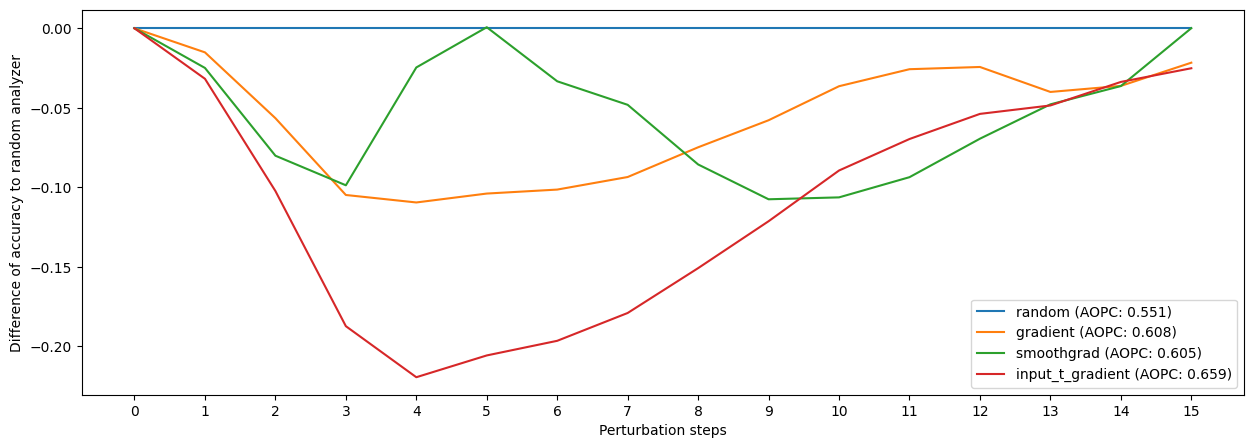

In [8]:
fig = plt.figure(figsize=(15, 5))
aopc = list()  # Area over the perturbation curve
baseline_accuracy = scores_selected_methods["random"][:, 1]
for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    accuracy = scores[:, 1]
    aopc.append(accuracy[0] - np.mean(accuracy))

    label = "{} (AOPC: {:.3f})".format(method_name, aopc[-1])
    plt.plot(accuracy - baseline_accuracy, label=label)

plt.xlabel("Perturbation steps")
plt.ylabel("Difference of accuracy to random analyzer")
plt.xticks(np.array(range(scores.shape[0])))
plt.legend()
plt.show()

As mentioned above, a steeper decrease shows a better identification of the relevant information.

## 2. Plot perturbed sample
Finally, we plot the perturbations on a selected test sample and show them along with the respective analyses.

<Figure size 640x480 with 0 Axes>

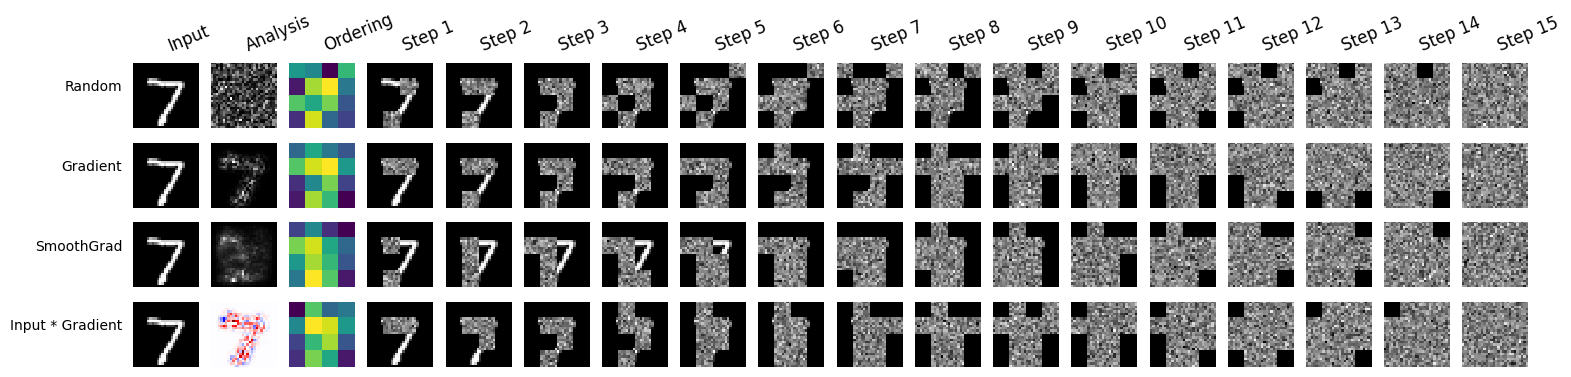

In [9]:
# Now plot the perturbation step by step.
plt.figure()
grid, row_labels = [], []
col_labels = ["Input", "Analysis", "Ordering"] + [
    "Step {}".format(i + 1) for i in range(steps)
]

for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.append([method[-1]])
    samples = list()

    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    analysis = perturbation_analysis.analyzer.analyze(sample)

    # Divide into regions and order them according to their analysis score
    # TODO backend channel ordering
    aggregated_regions = perturbation_analysis.perturbation.reduce_function(
        np.moveaxis(analysis, 3, 1), axis=1, keepdims=True
    )
    aggregated_regions = perturbation_analysis.perturbation._aggregate_regions(
        aggregated_regions
    )
    ranks = perturbation_analysis.perturbation._compute_region_ordering(
        aggregated_regions
    )

    # Perturbate for some steps
    for i in range(steps + 1):
        # Plot the original image and analysis without any perturbation
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += (
                perturbation_analysis.regions_per_step
            )
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        sample_to_show = mnistutils.postprocess(sample.repeat(3, axis=-1))
        analysis = mnistutils.postprocess(analysis)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        sample_to_show = np.clip(input_postprocessing(sample_to_show), 0, 1)

        samples.append(sample_to_show[0])
    # Plot analysis
    analysis = method[2](analysis)

    # Add analysis and ranking
    samples.insert(1, analysis[0])
    samples.insert(2, -ranks[0][0])

    grid.append(samples)

eutils.plot_image_grid(grid, row_labels, list(), col_labels)
plt.show()